# Imports

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pprint import pprint
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import GroupKFold
from sklearn.svm import SVR

from pandas.tools.plotting import table

from IPython.display import display, HTML

from scipy.stats import randint as sp_randint

import itertools

import keras
import keras.backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM, Activation

random_seed = 42
from tabulate import tabulate

import os

# Helper Functions

In [14]:
def savefig(name, pad=0.1,):
    path = os.path.join('images', name + '.png')
    plt.savefig(path, bbox_inches='tight', pad_inches=pad)
    
def train_validate_split(df):
    ids = df.id.unique()
    ids_validate = np.random.choice(ids, 10)
    ids_train = [i for i in ids if i not in ids_validate]
    train = df[df.id.isin(ids_train)]
    validate = df[df.id.isin(ids_validate)]
    
    return train, validate

def create_rf_dataset(train_df, test_df, variables, target):
    X_train = train_df[variables]
    y_train = train_df[target]
    X_test = test_df.groupby('id')[variables].last()
    y_test = test_df.groupby('id')[target].last()
    
    return X_train, y_train, X_test, y_test

def get_sequence(df, variables, target, lookback):
    X_data = df[variables].values
    y_data = df[target].values
    
    X = np.asarray([X_data[i: i+lookback, :] for i in range(X_data.shape[0] - lookback)]).astype(np.float32)
    y = y_data[lookback: y_data.shape[0]].astype(np.float32)
    
    return X, y

def create_reg_lstm_dataset(train_df, test_df, variables, target, lookback):
    lstm_variables = sensor_columns_var + [target]
    train_df_lstm = train_df[lstm_variables]
    test_df_lstm = test_df[lstm_variables]
    
    scaler = MinMaxScaler()
    
    train_df_lstm = pd.DataFrame(scaler.fit_transform(train_df_lstm), 
                             columns=train_df_lstm.columns, 
                             index=train_df_lstm.index).join(train_df['id'])

    test_df_lstm = pd.DataFrame(scaler.transform(test_df_lstm), 
                                 columns=test_df_lstm.columns, 
                                 index=test_df_lstm.index).join(test_df['id'])
    
    train_lstm, validate_lstm = train_validate_split(train_df_lstm)

    X_train, y_train = get_sequence(train_lstm, variables, target, lookback)
    X_validate, y_validate = get_sequence(validate_lstm, variables, target, lookback)

    test_ids = [i for i in test_df_lstm.id.unique() if test_df_lstm[test_df_lstm.id == i].shape[0] >= lookback]
    X_test = [test_df_lstm[test_df_lstm.id == unit_id][variables].values[-lookback:] for unit_id in test_ids]
    X_test = np.asarray(X_test).astype(np.float32)

    y_mask = [len(test_df_lstm[test_df_lstm['id']==id]) >= lookback for id in test_df_lstm['id'].unique()]
    y_test = test_df_lstm.groupby('id')[target].last()[y_mask].values
    y_test = y_test.reshape(y_test.shape[0],1).astype(np.float32)
    
    return X_train, y_train, X_validate, y_validate, X_test, y_test

def create_clf_lstm_dataset(train_df, test_df, variables, target, lookback):
    lstm_variables = sensor_columns_var
    train_df_lstm = train_df[lstm_variables]
    test_df_lstm = test_df[lstm_variables]
    
    scaler = MinMaxScaler()
    
    train_df_lstm = pd.DataFrame(scaler.fit_transform(train_df_lstm), 
                             columns=train_df_lstm.columns, 
                             index=train_df_lstm.index).join(train_df[['id', target]])

    test_df_lstm = pd.DataFrame(scaler.transform(test_df_lstm), 
                                 columns=test_df_lstm.columns, 
                                 index=test_df_lstm.index).join(test_df[['id', target]])
    
    train_lstm, validate_lstm = train_validate_split(train_df_lstm)

    X_train, y_train = get_sequence(train_lstm, variables, target, lookback)
    X_validate, y_validate = get_sequence(validate_lstm, variables, target, lookback)

    test_ids = [i for i in test_df_lstm.id.unique() if test_df_lstm[test_df_lstm.id == i].shape[0] >= lookback]
    X_test = [test_df_lstm[test_df_lstm.id == unit_id][variables].values[-lookback:] for unit_id in test_ids]
    X_test = np.asarray(X_test).astype(np.float32)

    y_mask = [len(test_df_lstm[test_df_lstm['id']==id]) >= lookback for id in test_df_lstm['id'].unique()]
    y_test = test_df_lstm.groupby('id')[target].last()[y_mask].values
    y_test = y_test.reshape(y_test.shape[0],1).astype(np.float32)
    
    return X_train, y_train, X_validate, y_validate, X_test, y_test  

def plot_reg_result(ax, true, pred, title='', n=200):
    ax.scatter(true, pred)
    x = np.arange(n)
    ax.plot(x, x, color='black')
    ax.set_xlim(0,n)
    ax.set_ylim(0,n)
    ax.set_title(title, fontsize=18)
    ax.grid(True)
    ax.set_xlabel('True RUL')
    ax.set_ylabel('Predicted RUL')
        
def plot_cm(ax, y_test, y_pred, title, multi=False):

    if multi:
        classes=[0,1,2]
    else:
        classes=[0,1]

    cm = confusion_matrix(y_test, y_pred, labels=classes)
    ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                fontsize=16)
    ax.set_title(title, fontsize=18)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    

# Data Ingestion

The training data consists of multiple multivariate time series with "cycle" as the time unit, together with 21 sensor readings for each cycle. Each time series can be assumed as being generated from a different engine of the same type. The testing data has the same data schema as the training data. The only difference is that the data does not indicate when the failure occurs. Finally, the ground truth data provides the number of remaining working cycles for the engines in the testing data.

In [4]:
train_df = pd.read_csv('data/train_data.csv')
test_df = pd.read_csv('data/test_data.csv')
truth_df = pd.read_csv('data/truth_data.csv')

## Train

In [4]:
print('Number of rows: {}, number of features: {}'.format(*train_df.shape))
display(train_df.head())

Number of rows: 20631, number of features: 26


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


## Test

In [5]:
print('Number of rows: {}, number of features: {}'.format(*test_df.shape))
display(test_df.head())

Number of rows: 13096, number of features: 26


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


## Truth

In [6]:
print('Number of rows: {}, number of features: {}'.format(*truth_df.shape))
display(truth_df.head())

Number of rows: 100, number of features: 1


,extra_cycles
0,112
1,98
2,69
3,82
4,91


# Create Labels

## Train

In [5]:
engine_lifetimes = train_df.groupby('id')['cycle'].max()
train_df['RUL'] = train_df.apply(lambda r: (engine_lifetimes[r.id] - r.cycle).astype(int), axis=1)

In [6]:
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df.RUL < w1, 1, 0)

def calc_label2(rul):
    if rul >= w1: 
        return 0
    elif rul < w1 and rul > w0: 
        return 1
    else: 
        return 2
        
train_df['label2'] = train_df.RUL.apply(calc_label2)

In [9]:
head = train_df[train_df.id==1][['id', 'cycle', 'RUL', 'label1', 'label2']].head()
tail = train_df[train_df.id==1][['id', 'cycle', 'RUL', 'label1', 'label2']].tail()
display(pd.concat([head, tail]))

,id,cycle,RUL,label1,label2
0,1,1,191,0,0
1,1,2,190,0,0
2,1,3,189,0,0
3,1,4,188,0,0
4,1,5,187,0,0
187,1,188,4,1,2
188,1,189,3,1,2
189,1,190,2,1,2
190,1,191,1,1,2
191,1,192,0,1,2


## Test

In [7]:
# Use the ground truth data to make the RUL column on the test dataset
truth_df['max_cycles'] = test_df.groupby('id')['cycle'].max().values + truth_df.extra_cycles

# Create the labels for the test data
test_df['RUL'] = test_df.apply(lambda row: (truth_df.max_cycles[row.id-1] - row.cycle).astype(int), axis=1)
test_df['label1'] = np.where(test_df.RUL < w1, 1, 0)
test_df['label2'] = test_df.RUL.apply(calc_label2)

In [12]:
head = test_df[test_df.id==1][['id', 'cycle', 'RUL', 'label1', 'label2']].head()
tail = test_df[test_df.id==1][['id', 'cycle', 'RUL', 'label1', 'label2']].tail()
display(pd.concat([head, tail]))

,id,cycle,RUL,label1,label2
0,1,1,142,0,0
1,1,2,141,0,0
2,1,3,140,0,0
3,1,4,139,0,0
4,1,5,138,0,0
26,1,27,116,0,0
27,1,28,115,0,0
28,1,29,114,0,0
29,1,30,113,0,0
30,1,31,112,0,0


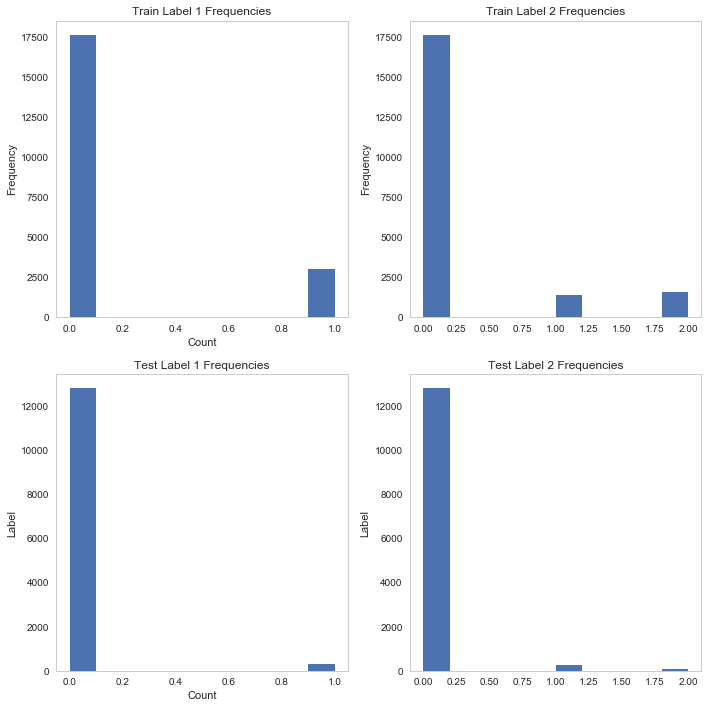

In [47]:
fig, ax = plt.subplots(2,2,figsize=(10,10))

train_df['label1'].plot(kind='hist', ax=ax[0][0])
train_df['label2'].plot(kind='hist', ax=ax[0][1])
test_df['label1'].plot(kind='hist', ax=ax[1][0])
test_df['label2'].plot(kind='hist', ax=ax[1][1])

ax[0][0].set_title('Train Label 1 Frequencies')
ax[0][0].set_xlabel('Count')
ax[0][1].set_title('Train Label 2 Frequencies')
ax[1][0].set_title('Test Label 1 Frequencies')
ax[1][0].set_xlabel('Count')
ax[1][0].set_ylabel('Label')
ax[1][1].set_title('Test Label 2 Frequencies')
ax[1][1].set_ylabel('Label')

plt.tight_layout()
plt.show()

# Data Exploration

In [8]:
sensor_columns = ['s{}'.format(i) for i in range(1, 22)]
setting_columns = ['setting1', 'setting2', 'setting3']

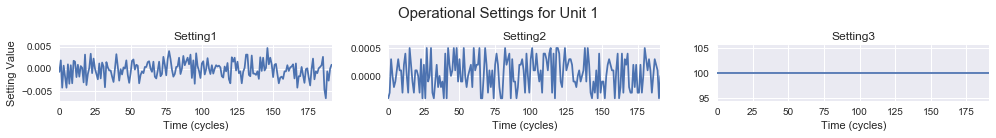

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,2))
train_df[train_df.id == 1]['setting1'].plot(ax=ax1)
ax1.set_title('Setting1')
ax1.set_xlabel('Time (cycles)')
ax1.set_ylabel('Setting Value')
train_df[train_df.id == 1]['setting2'].plot(ax=ax2)
ax2.set_title('Setting2')
ax2.set_xlabel('Time (cycles)')
train_df[train_df.id == 1]['setting3'].plot(ax=ax3)
ax3.set_title('Setting3')
ax3.set_xlabel('Time (cycles)')

fig.suptitle('Operational Settings for Unit 1', fontsize=15)
fig.tight_layout(rect=[0, 0.03, 1, 0.9])
savefig('operational_settings')

In [15]:
def plot_sensors(df, unit_id=1):
    unit_df = df[df.id == unit_id]
    fig, axes = plt.subplots(7, 3, figsize=(15, 10), sharex=True)

    for index, ax in enumerate(axes.ravel()):
        col = sensor_columns[index]
        unit_df.plot(x='cycle', y=col, ax=ax, legend=False)
        if index % 3 == 0: ax.set_ylabel("Sensor Value")
        ax.set_xlabel("Time (cycles)")
        ax.set_title("Sensor {}".format(index + 1))

    fig.tight_layout()
    fig.suptitle("Sensor Traces for Engine ID {}".format(unit_id), size=20, y=1.025)

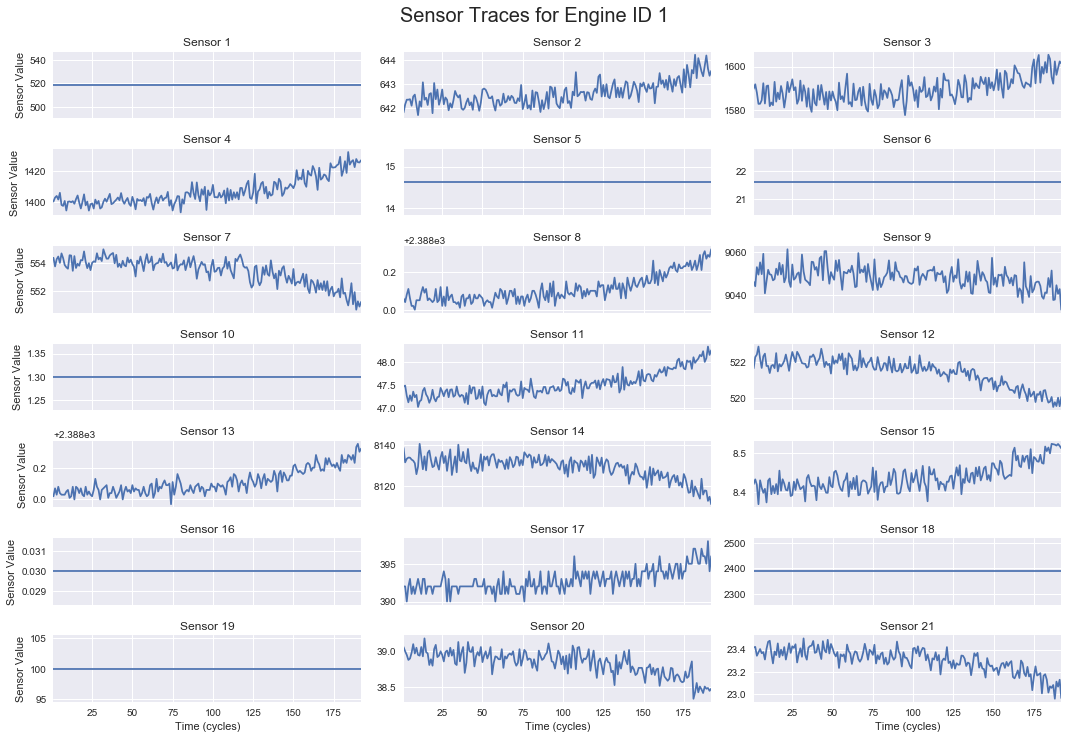

In [16]:
plot_sensors(train_df, unit_id=1)
savefig('sensor_values')

In [17]:
def plot_sensor_hist(df, sensor='s1', n=20):
    df.groupby('id').head(n)[sensor].plot(kind='hist', bins=20, label='Healthy', color='green', figsize=(8,4))
    df.groupby('id').tail(n)[sensor].plot(kind='hist', bins=20, label='Failing', color='red', figsize=(8,4))
    plt.title('Healthy vs Failing Sensor Values')
    plt.ylabel('Count')
    plt.xlabel('Value of Sensor {}'.format(sensor[1:]))
    plt.legend()

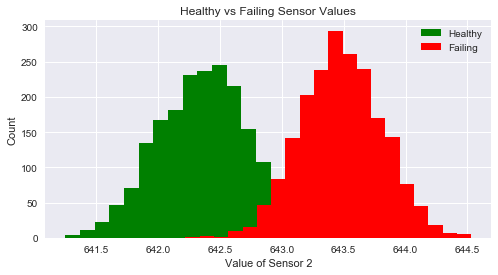

In [18]:
plot_sensor_hist(train_df, 's2')
savefig('sensor_hist')

In [19]:
def plot_sensors_multiple(df, columns, x_label='cycle', number_units=10, window=10):
    ids = df['id'].unique()
    units_to_plot = np.random.choice(ids, size=number_units, replace=False)
    plot_data = df[df.id.isin(units_to_plot)]
    fig, axes = plt.subplots(7, 3, figsize=(15, 10), sharex=True)

    for index, ax in enumerate(axes.ravel()):
        col = columns[index]
        for unit_id, group in plot_data.groupby('id'):
            group.plot(x=x_label, y=col, alpha=0.45, ax=ax, color='gray', legend=False)
            group.rolling(window=window, on='cycle').mean().plot(x=x_label, y=col, alpha=.75, ax=ax,
                                                                 color='black', legend=False)
        if index % 3 == 0: ax.set_ylabel("Sensor Value")
        ax.set_xlabel("Time (Cycles)")
        ax.set_title("Sensor {}".format(index+1))

        if x_label == 'RUL':
            ax.axvline(x=0, color='r', linewidth=3)
            ax.set_xlim([250, -10]);

    fig.suptitle("Sensor Traces", size=20, y=1.025)
    fig.tight_layout()

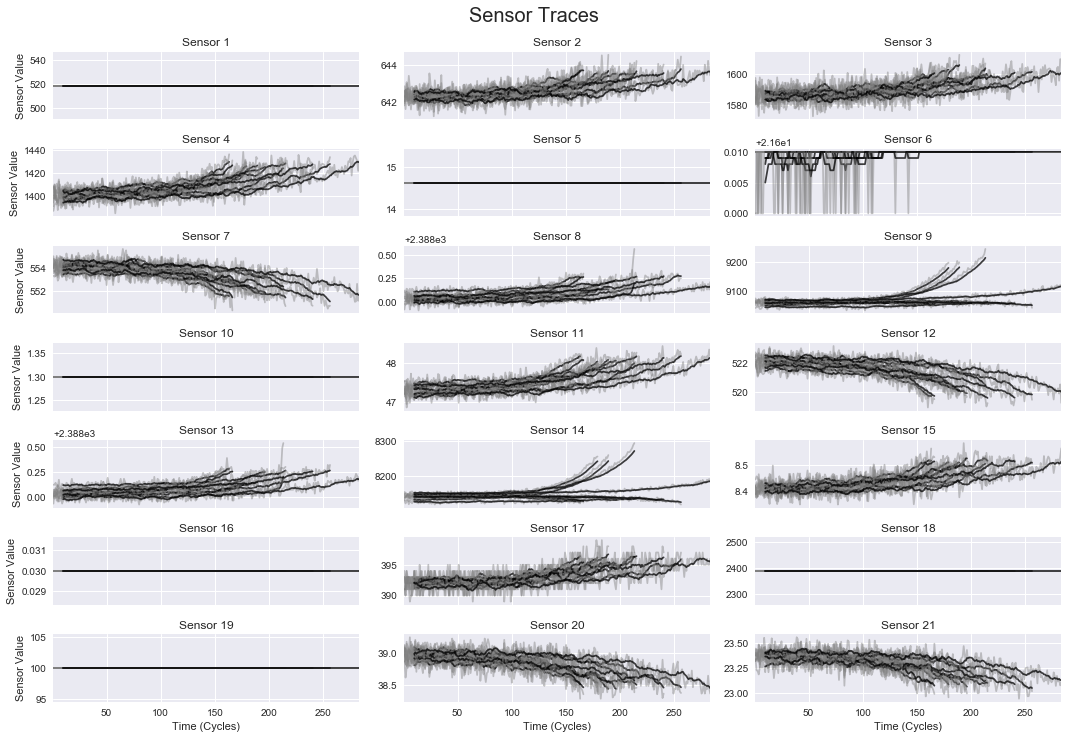

In [20]:
plot_sensors_multiple(train_df, columns=sensor_columns)
savefig('sensors_multiple')

In [21]:
def plot_sensors_multiple_rul(df, number_units=10, window=10):
    ids = df['id'].unique()
    units_to_plot = np.random.choice(ids, size=number_units, replace=False)
    plot_data = df[df.id.isin(units_to_plot)]
    fig, axes = plt.subplots(7, 3, figsize=(15, 10), sharex=True)

    for index, ax in enumerate(axes.ravel()):
        col = sensor_columns[index]
        for unit_id, group in plot_data.groupby('id'):
            group.plot(x='RUL', y=col, alpha=0.5, ax=ax, color='gray', legend=False)
            group.rolling(window=window, on='cycle').mean().plot(x='RUL', y=col, alpha=.75, ax=ax,
                                                                 color='black', legend=False)
        if index % 3 == 0: ax.set_ylabel("Sensor Value")
        ax.set_xlabel("Time (Cycles)")
        ax.set_title("Sensor {}".format(index+1))

        ax.axvline(x=0, color='r', linewidth=3)
        ax.set_xlim([250, -10])

    fig.suptitle("Sensor Traces", size=20, y=1.025)
    fig.tight_layout()

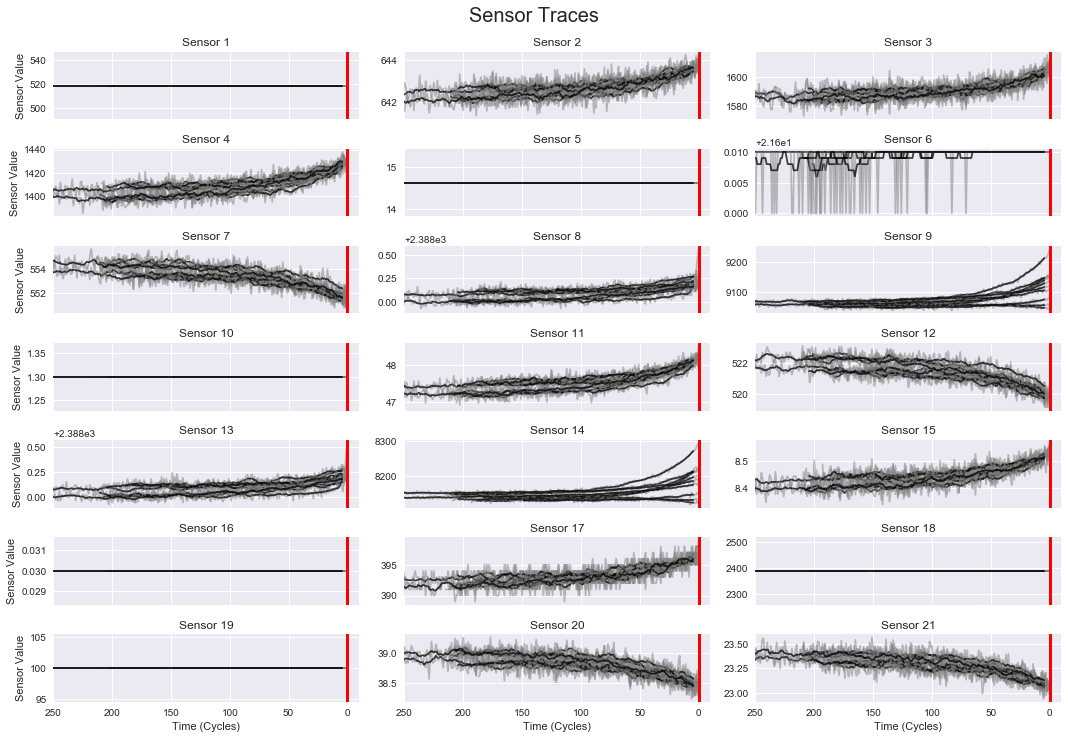

In [22]:
plot_sensors_multiple_rul(train_df)
savefig('sensors_rul')

In [25]:
def plot_last_n_cycles(df, unit_id=1):
    unit_df = df[df.id == unit_id]
    fig, axes = plt.subplots(7, 3, figsize=(15, 10), sharex=True)

    for index, ax in enumerate(axes.ravel()):
        col = sensor_columns[index]
        unit_df.plot(x='RUL', y=col, ax=ax, legend=False, alpha=1)

        if index % 3 == 0: ax.set_ylabel("Sensor Value")
        ax.set_xlabel("Time Before Failure (Cycles)")
        ax.set_title("Sensor {}".format(index+1))

        ax.axvline(x=0, color='r', linewidth=3)
        ax.set_xlim([None, -10])

    fig.tight_layout()

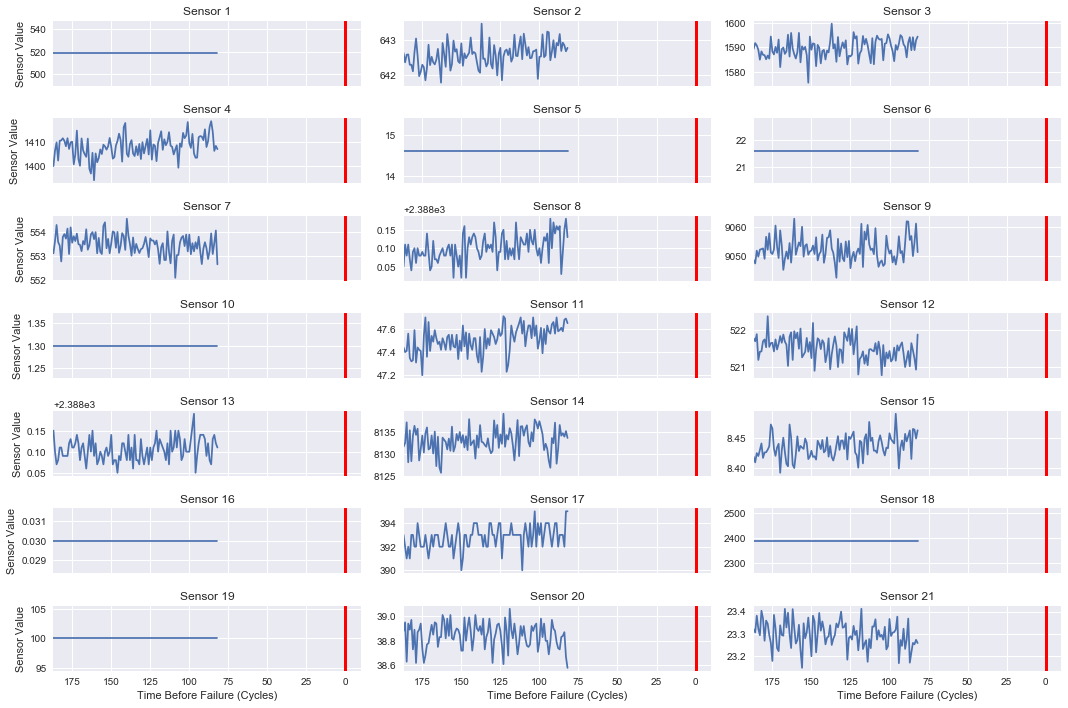

In [29]:
plot_last_n_cycles(test_df, unit_id=4)
savefig('test_sensor_rul')

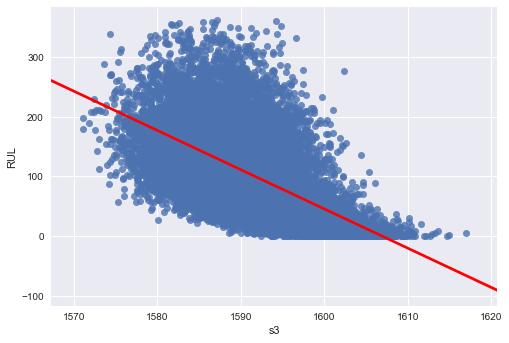

In [30]:
sns.regplot(x=train_df.s3, y=train_df.RUL, line_kws={'color': 'red'})
savefig('s3_linear_reg')

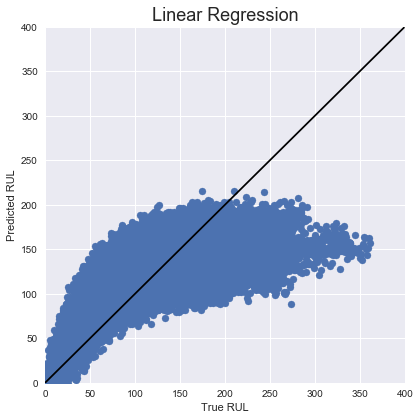

In [36]:
X_train, y_train, X_test, y_test = create_rf_dataset(train_df, test_df, variables=sensor_columns_var, target='RUL')
model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_train)
plot_reg_result(y_train, y_pred, title='Linear Regression', n=400)
savefig('train_linear_regression')

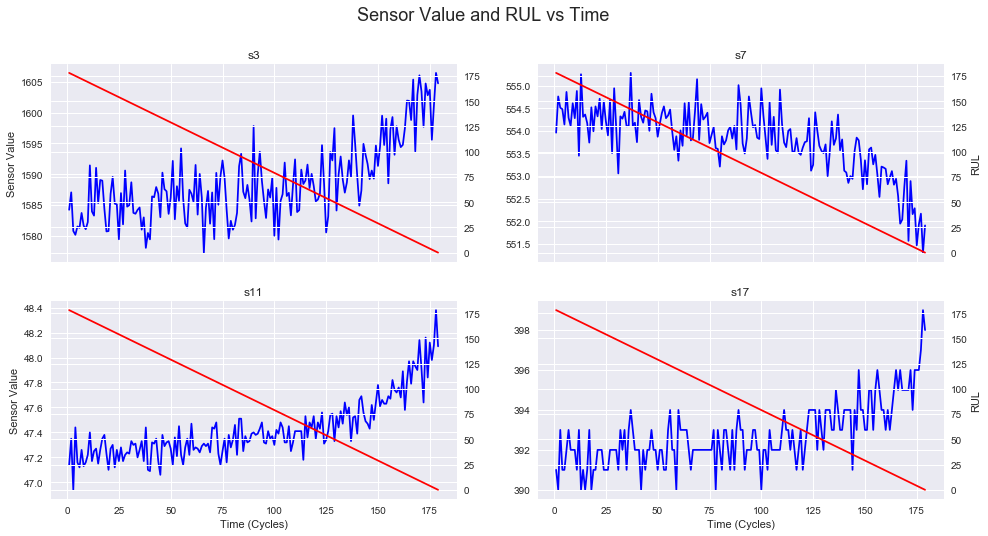

In [138]:
fig, axes = plt.subplots(2,2,figsize=(16,8), sharex=True)
sensors = ['s3', 's7', 's11', 's17']

for index, ax in enumerate(axes.ravel()):
    x = train_df[train_df.id==3].cycle
    ax.plot(x, train_df[train_df.id==3][sensors[index]], color='blue')
    ax2 = ax.twinx()
    ax2.plot(x, train_df[train_df.id==3].RUL, color='red')
    
    ax.set_title(sensors[index])
    
    if index % 2 == 0:
        ax.set_ylabel('Sensor Value')
    else:
        ax2.set_ylabel('RUL')
        
    if index > 1:
        ax.set_xlabel('Time (Cycles)')
        
fig.suptitle('Sensor Value and RUL vs Time', fontsize=18)
savefig('rul_and_sensor_value')

# Metrics

In [9]:
def rul_performance_metric(true, pred):
    error = pred - true
    return  np.mean(np.where(error < 0, np.exp(-error/14) - 1, np.exp(error/11) - 1))

def label1_performance_metric(true, pred):
    error = pred - true
    return  np.sum(np.where(error == -1, -2*error, error))

def label2_performance_metric(true, pred):
    error = pred - true
    return np.sum(np.where(error < 0, -3*error, error))

In [10]:
def rul_performance_metric_keras(y_true, y_pred):
    error = y_pred - y_true
    return  K.mean(K.tf.where(error < 0, K.exp(-error/13) - 1, K.exp(error/10) - 1))

def label1_performance_metric_keras(y_true, y_pred):
    error = y_pred - y_true
    return K.sum(K.tf.where(error == -1, -2 * error, error))

def label2_performance_metric_keras(y_true, y_pred):
    error = y_pred - y_true
    return K.sum(K.tf.where(error < 0, -3*error, error))

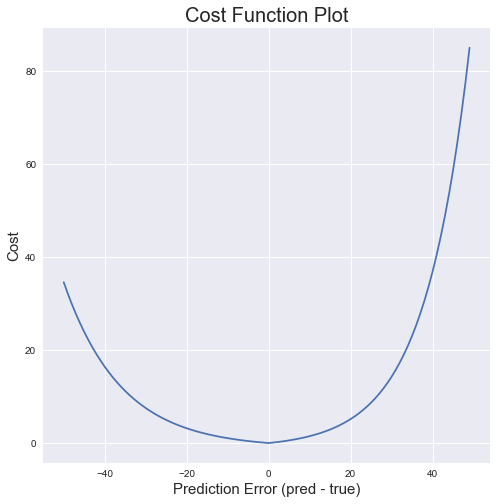

In [107]:
def rul_cost_function_plot(error):
    return np.exp(-error/14) - 1 if error < 0 else np.exp(error/11) - 1

plt.figure(figsize=(8,8))
pred_error = np.arange(-50, 50)
cost_error = np.asarray([rul_cost_function_plot(error) for error in pred_error])
plt.plot(pred_error, cost_error)
plt.title('Cost Function Plot', fontsize=20)
plt.xlabel('Prediction Error (pred - true)', fontsize=15)
plt.ylabel('Cost', fontsize=15)
savefig('cost_function_plot')

# Benchmark Models

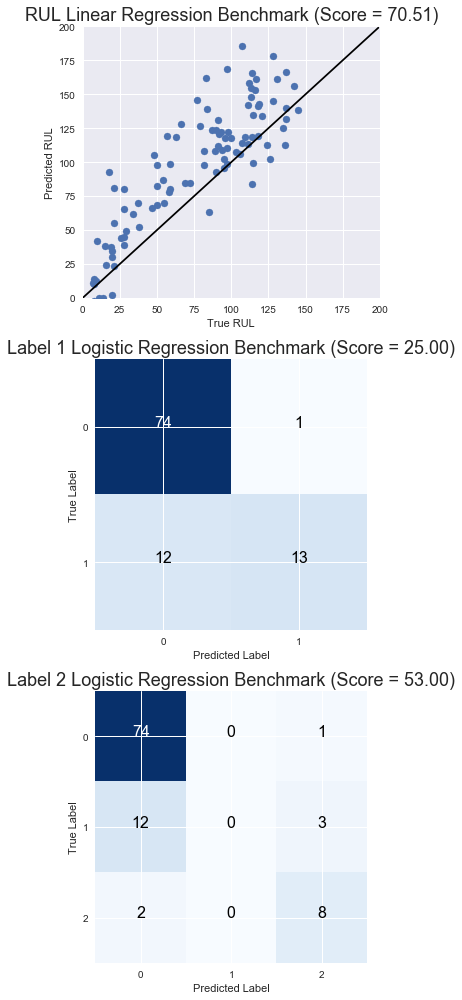

In [15]:
X_train = train_df[sensor_columns]
y_train_rul = train_df['RUL']
y_train_label1 = train_df['label1']
y_train_label2 = train_df['label2']

X_test = test_df.groupby('id')[sensor_columns].last()
y_test_rul = test_df.groupby('id')['RUL'].last()
y_test_label1 = test_df.groupby('id')['label1'].last()
y_test_label2 = test_df.groupby('id')['label2'].last()

rul_pred = LinearRegression().fit(X_train, y_train_rul).predict(X_test)
label1_pred = LogisticRegression().fit(X_train, y_train_label1).predict(X_test)
label2_pred = LogisticRegression().fit(X_train, y_train_label2).predict(X_test)

benchmark_score_rul = rul_performance_metric(y_test_rul, rul_pred)
benchmark_score_label1 = label1_performance_metric(y_test_label1, label1_pred)
benchmark_score_label2 = label2_performance_metric(y_test_label2, label2_pred)

titles = [
    'RUL Linear Regression Benchmark (Score = {0:.2f})'.format(benchmark_score_rul),
    'Label 1 Logistic Regression Benchmark (Score = {0:.2f})'.format(benchmark_score_label1),
    'Label 2 Logistic Regression Benchmark (Score = {0:.2f})'.format(benchmark_score_label2)
]

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(6,14))
plot_reg_result(ax1, y_test_rul, rul_pred, title=titles[0], n=200)
plot_cm(ax2, y_test_label1, label1_pred, titles[1], multi=False)
plot_cm(ax3, y_test_label2, label2_pred, titles[2], multi=True)
plt.tight_layout()

savefig('benchmarks', pad=0.1)

# Feature Engineering

In [16]:
sensor_columns_var = np.asarray(sensor_columns)[np.abs(train_df[sensor_columns].var()) > 0.00001].tolist()
rolling_mean_columns = [c.replace('s', 'mean') for c in sensor_columns_var]
rolling_std_columns = [c.replace('s', 'std') for c in sensor_columns_var]
agg_cols = rolling_mean_columns + rolling_std_columns

In [17]:
def create_aggregate_features(df, window=5):
    for unit_id, group in df.groupby('id'):
        df[rolling_mean_columns] = df[sensor_columns_var].rolling(window=window, min_periods=1).mean()
        df[rolling_std_columns] = df[sensor_columns_var].rolling(window=window, min_periods=1).std()
    
    return df.fillna(method='bfill')

In [18]:
train_df = create_aggregate_features(train_df)
test_df = create_aggregate_features(test_df)

In [60]:
train_df[['id', 'cycle', 's2', 'mean2', 'std2']].head()

,id,cycle,s2,mean2,std2
0,1,1,641.82,641.820000,0.233345
1,1,2,642.15,641.985000,0.233345
2,1,3,642.35,642.106667,0.267644
3,1,4,642.35,642.167500,0.250117
4,1,5,642.37,642.208000,0.234776


# Modelling

In [19]:
def fit_rf_model(X, y, target):
    cv_sets = list(GroupKFold(n_splits=5).split(X, y, groups=train_df['id']))

    if target == 'RUL':
        model = RandomForestRegressor(random_state=42)
        scoring_fnc = make_scorer(rul_performance_metric)
        
        params = {"max_depth": sp_randint(1, 100),
                  "max_features": sp_randint(1, 11),
                  "min_samples_split": sp_randint(2, 11),
                  "min_samples_leaf": sp_randint(1, 11),
                  "bootstrap": [True, False],
                  "criterion": ["mse"]}
        
    else:
        model = RandomForestClassifier(random_state=42)
        if target == 'label1':
            scoring_fnc = make_scorer(label1_performance_metric)
        else:
            scoring_fnc = make_scorer(label2_performance_metric)

        params = {"max_depth": sp_randint(1, 100),
                  "max_features": sp_randint(1, 11),
                  "min_samples_split": sp_randint(2, 11),
                  "min_samples_leaf": sp_randint(1, 11),
                  "bootstrap": [True, False],
                  "criterion": ["gini", "entropy"]}

    grid = RandomizedSearchCV(model, params, scoring=scoring_fnc, cv=cv_sets, n_iter=20).fit(X, y)
    return grid.best_estimator_

In [20]:
def show_all_results(train_df, test_df, train_rul=True, train_label1=True, train_label2=True, refine=False):
    '''
    Get Results
    '''
    
    sns.set_style("whitegrid", {'axes.grid' : False})
    
    '''
    Paths to save lstm models
    '''
    if refine:
        rul_path = 'models/ref_lstm_regression_model.h5'
        label1_path = 'models/ref_lstm_classification_model.h5'
        label2_path = 'models/ref_lstm_multi_classification_model.h5'
    else:
        rul_path = 'models/lstm_regression_model.h5'
        label1_path = 'models/lstm_classification_model.h5'
        label2_path = 'models/lstm_multi_classification_model.h5'
    
    lookback = 50
    linear_variables = sensor_columns_var + agg_cols
    lstm_variables = sensor_columns_var
    
    '''
    Create the datasets
    '''
    # X_train for LR and RF
    X_train_linear = train_df[linear_variables]
    
    # y_train for LR and RF
    y_train_rul = train_df['RUL']
    y_train_label1 = train_df['label1']
    y_train_label2 = train_df['label2']
    
    # X_train for LR and RF
    X_test_linear = test_df.groupby('id')[linear_variables].last()
    
    # y_test for LR and RF
    y_test_linear_rul = test_df.groupby('id')['RUL'].last()
    y_test_linear_label1 = test_df.groupby('id')['label1'].last()
    y_test_linear_label2 = test_df.groupby('id')['label2'].last()
    
    # LSTM datsets
    X_train_lstm_rul, y_train_lstm_rul, X_validate_lstm_rul, y_validate_lstm_rul, X_test_lstm_rul, y_test_lstm_rul_norm =\
    create_reg_lstm_dataset(train_df, test_df, variables=sensor_columns_var, target='RUL', lookback=50)
    
    X_train_lstm_label1, y_train_lstm_label1, X_validate_lstm_label1, y_validate_lstm_label1, X_test_lstm_label1, y_test_lstm_label1 =\
    create_clf_lstm_dataset(train_df, test_df, variables=sensor_columns_var, target='label1', lookback=50)
    
    X_train_lstm_label2, y_train_lstm_label2, X_validate_lstm_label2, y_validate_lstm_label2, X_test_lstm_label2, y_test_lstm_label2 =\
    create_clf_lstm_dataset(train_df, test_df, variables=sensor_columns_var, target='label2', lookback=50)

    
    '''
    Train the models and make predictions
    '''
    
    # RUL
    print('starting RUL Linear')
    rul_pred_lr = LinearRegression().fit(X_train_linear, y_train_rul).predict(X_test_linear)
    rul_score_lr = rul_performance_metric(y_test_linear_rul, rul_pred_lr)
    
    print('starting RUL Random Forest')
    rul_rf_model = fit_rf_model(X_train_linear, y_train_rul, target='RUL').fit(X_train_linear, y_train_rul)
    rul_pred_rf = rul_rf_model.predict(X_test_linear)
    rul_score_rf = rul_performance_metric(y_test_linear_rul, rul_pred_rf)
            
    print('starting RUL LSTM')
    if train_rul:
        rul_lstm_model = Sequential()
        rul_lstm_model.add(LSTM(100, input_shape=(X_train_lstm_rul.shape[1], X_train_lstm_rul.shape[2]), return_sequences=True))
        rul_lstm_model.add(Dropout(0.2))
        rul_lstm_model.add(LSTM(units=50, return_sequences=False))
        rul_lstm_model.add(Dropout(0.2))
        rul_lstm_model.add(Dense(1))
        rul_lstm_model.add(Activation("linear"))

        rul_lstm_model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=[rul_performance_metric_keras])

        rul_lstm_model.fit(X_train_lstm_rul, y_train_lstm_rul, 
                    epochs=20, batch_size=200, validation_data=(X_validate_lstm_rul, y_validate_lstm_rul), verbose=0,
                    callbacks = [keras.callbacks.ModelCheckpoint(
                                rul_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)])
    
    rul_lstm_model = load_model(rul_path, 
                                custom_objects={'rul_performance_metric_keras': rul_performance_metric_keras})
    
    rul_pred_lstm_norm = rul_lstm_model.predict(X_test_lstm_rul)
    rul_scaler = MinMaxScaler().fit(train_df.RUL.reshape(-1, 1))
    rul_pred_lstm = rul_scaler.inverse_transform(rul_pred_lstm_norm)
    y_test_lstm_rul = rul_scaler.inverse_transform(y_test_lstm_rul_norm)
    
    rul_score_lstm = rul_performance_metric(y_test_lstm_rul, rul_pred_lstm)
            
    
    # Label1
    print('starting label1 Linear')
    label1_pred_lr = LogisticRegression().fit(X_train_linear, y_train_label1).predict(X_test_linear)
    label1_score_lr = label1_performance_metric(y_test_linear_label1, label1_pred_lr)
    
    print('starting label1 Random Forrest')
    label1_rf_model = fit_rf_model(X_train_linear, y_train_label1, target='label1').fit(X_train_linear, y_train_label1)
    label1_pred_rf = label1_rf_model.predict(X_test_linear)
    label1_score_rf = label1_performance_metric(y_test_linear_label1, label1_pred_rf)
            
    print('starting Label1 LSTM')
    if train_label1:
        label1_lstm_model = Sequential()
        label1_lstm_model.add(LSTM(100, input_shape=(X_train_lstm_label1.shape[1], X_train_lstm_label1.shape[2]), return_sequences=True))
        label1_lstm_model.add(Dropout(0.2))
        label1_lstm_model.add(LSTM(units=50, return_sequences=False))
        label1_lstm_model.add(Dropout(0.2))
        label1_lstm_model.add(Dense(1, activation='sigmoid'))
        label1_lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[label1_performance_metric_keras])

        label1_lstm_model.fit(X_train_lstm_label1, y_train_lstm_label1, 
                    epochs=20, batch_size=200, validation_data=(X_validate_lstm_label1, y_validate_lstm_label1), verbose=0,
                    callbacks = [keras.callbacks.ModelCheckpoint(
                                label1_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])
    
    label1_lstm_model = load_model(label1_path, 
                                   custom_objects={'label1_performance_metric_keras': label1_performance_metric_keras})
    
    label1_pred_lstm = np.round(label1_lstm_model.predict(X_test_lstm_label1))
        
    label1_score_lstm = label1_performance_metric(y_test_lstm_label1, label1_pred_lstm)
            
    # Label2
    print('starting label2 Linear')
    label2_pred_lr = LogisticRegression().fit(X_train_linear, y_train_label2).predict(X_test_linear)
    label2_score_lr = label2_performance_metric(y_test_linear_label2, label2_pred_lr)
    
    print('starting label2 Random Forrest')
    label2_rf_model = fit_rf_model(X_train_linear, y_train_label2, target='label2').fit(X_train_linear, y_train_label2)
    label2_pred_rf = label2_rf_model.predict(X_test_linear)
    label2_score_rf = label2_performance_metric(y_test_linear_label2, label2_pred_rf)
            
    print('starting Label2 LSTM')
    if train_label2:
        label2_lstm_model = Sequential()
        label2_lstm_model.add(LSTM(100, input_shape=(X_train_lstm_label2.shape[1], X_train_lstm_label2.shape[2]), return_sequences=True))
        label2_lstm_model.add(Dropout(0.2))
        label2_lstm_model.add(LSTM(units=50, return_sequences=False))
        label2_lstm_model.add(Dropout(0.2))
        label2_lstm_model.add(Dense(3, activation='softmax'))
        label2_lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', 
                                  metrics=[label2_performance_metric_keras])    

        label2_lstm_model.fit(X_train_lstm_label2, y_train_lstm_label2, 
                    epochs=20, batch_size=200, validation_data=(X_validate_lstm_label2, y_validate_lstm_label2), verbose=0,
                    callbacks = [keras.callbacks.ModelCheckpoint(
                                label2_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])
    
    label2_lstm_model = load_model(label2_path, 
                                   custom_objects={'label2_performance_metric_keras': label2_performance_metric_keras})
    
    label2_probs = label2_lstm_model.predict(X_test_lstm_label2)
    label2_pred_lstm = np.asarray([np.argmax(p) for p in label2_probs]).reshape(-1,1)
    
    label2_score_lstm = label2_performance_metric(y_test_lstm_label2, label2_pred_lstm)
    
    y_test = [
        y_test_linear_rul, y_test_linear_rul, y_test_lstm_rul,
        y_test_linear_label1, y_test_linear_label1, y_test_lstm_label1,
        y_test_linear_label2, y_test_linear_label2, y_test_lstm_label2
    ]
    
    y_pred = [
        rul_pred_lr, rul_pred_rf, rul_pred_lstm,
        label1_pred_lr, label1_pred_rf, label1_pred_lstm,
        label2_pred_lr, label2_pred_rf, label2_pred_lstm
    ]
    
    titles = [
        'RUL Linear Regression (Score = {0:.2f})'.format(rul_score_lr),
        'RUL Random Forrest (Score = {0:.2f})'.format(rul_score_rf),
        'RUL LSTM (Score = {0:.2f})'.format(rul_score_lstm),
        'Label 1 Linear Regression (Score = {0:.2f})'.format(label1_score_lr),
        'Label 1 Random Forrest (Score = {0:.2f})'.format(label1_score_rf),
        'Label 1 LSTM (Score = {0:.2f})'.format(label1_score_lstm),
        'Label 2 Linear Regression (Score = {0:.2f})'.format(label2_score_lr),
        'Label 2 Random Forrest (Score = {0:.2f})'.format(label2_score_rf),
        'Label 2 LSTM (Score = {0:.2f})'.format(label2_score_lstm),
    ]
    
    results_df = pd.DataFrame(data={
        'RUL': [benchmark_score_rul, rul_score_lr, rul_score_rf, rul_score_lstm],
        'Label1': [benchmark_score_label1, label1_score_lr, label1_score_rf, label1_score_lstm],
        'Label2': [benchmark_score_label2, label2_score_lr, label2_score_rf, label2_score_lstm]},
        columns=['RUL', 'Label1', 'Label2'],
        index=['Benchmark', 'Linear', 'RandomForrest', 'LSTM']
    )
    
    display(results_df)
    
    fig, axes = plt.subplots(3, 3, figsize=(21, 21))
    for index, ax in enumerate(axes.ravel()):
        if index < 3:
            plot_reg_result(ax, y_test[index], y_pred[index], title=titles[index], n=200)
        elif index < 6:
            plot_cm(ax, y_test[index], y_pred[index], title=titles[index])
        else:
            plot_cm(ax, y_test[index], y_pred[index], title=titles[index], multi=True)
            
    if refine:
        savefig('refined_results')
    else:
        savefig('results')
        
    return results_df

starting RUL Linear
starting RUL Random Forest
starting RUL LSTM
starting label1 Linear
starting label1 Random Forrest
starting Label1 LSTM
starting label2 Linear
starting label2 Random Forrest
starting Label2 LSTM


,RUL,Label1,Label2
Benchmark,70.507539,25.0,53.0
Linear,58.326902,21.0,51.0
RandomForrest,45.809363,21.0,37.0
LSTM,11.443426,4.0,17.0


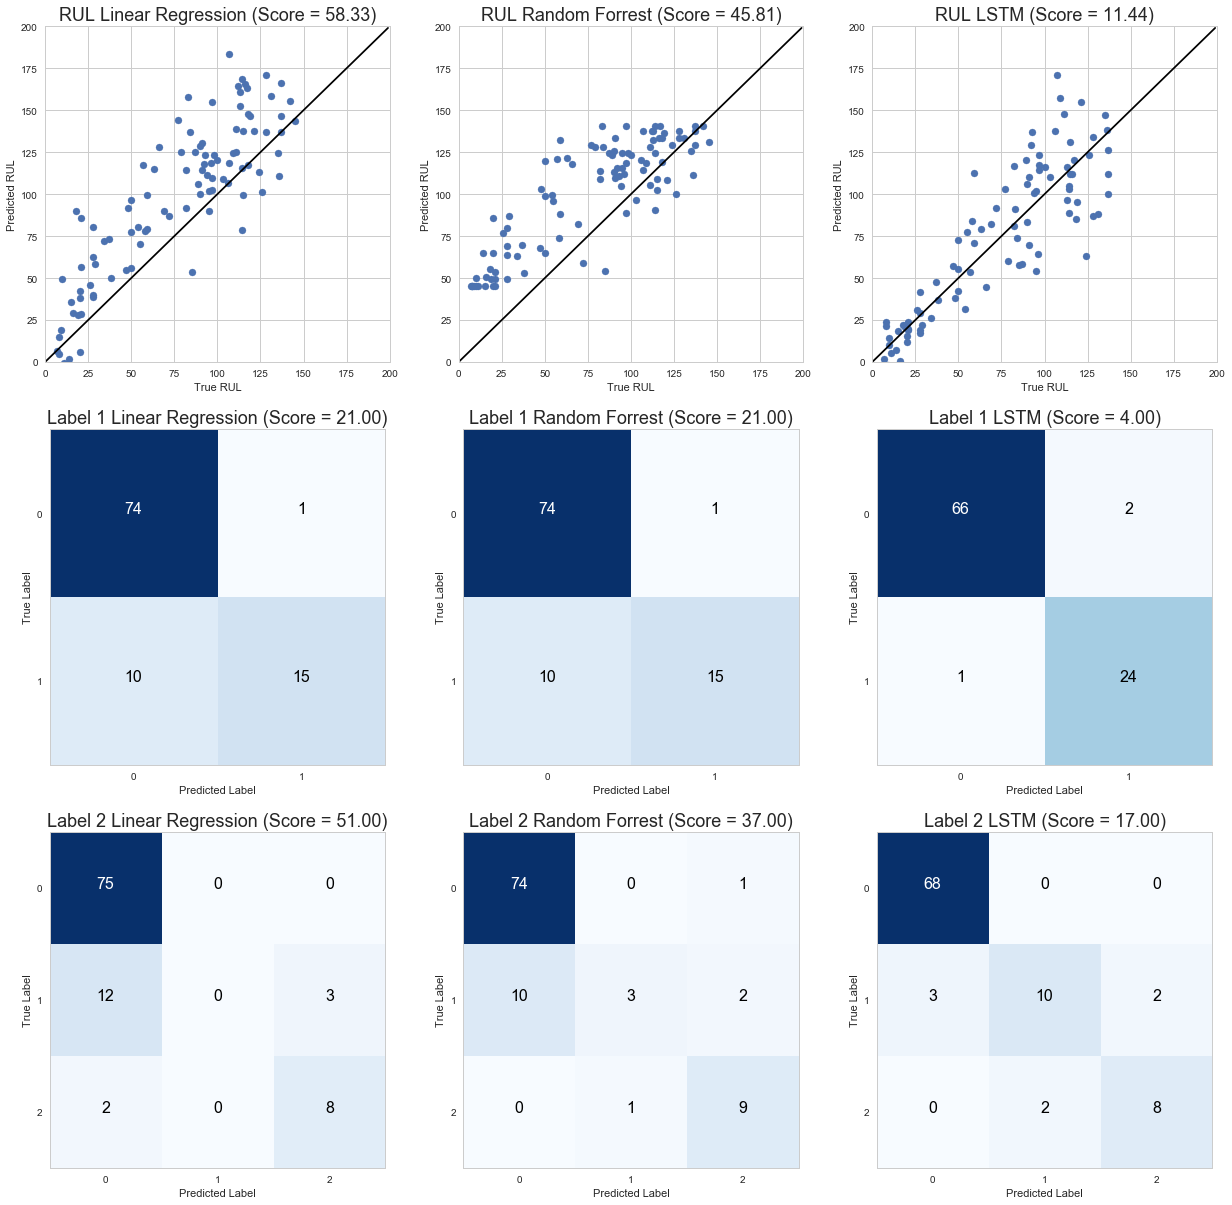

In [21]:
results_df = show_all_results(train_df, test_df, train_rul=False, train_label1=False, train_label2=False, refine=False)

# Refinement

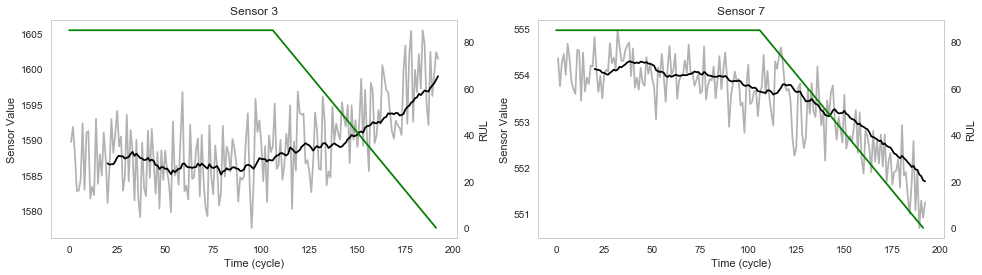

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

tdf = train_df_ref[train_df_ref.id==1]

x = tdf.cycle

ax1.plot(x, tdf.s3, alpha=0.6, color='grey')
ax1.plot(x, tdf.s3.rolling(window=20).mean(), color='black')
ax1.set_xlabel('Time (cycle)')
ax1.set_ylabel('Sensor Value')
ax1.set_title('Sensor 3')

ax12 = ax1.twinx()
ax12.plot(tdf.RUL, color='green')
ax12.set_ylabel('RUL')

ax2.plot(x, tdf.s7, alpha=0.6, color='grey')
ax2.plot(x, tdf.s7.rolling(window=20).mean(), color='black')
ax2.set_xlabel('Time (cycle)')
ax2.set_ylabel('Sensor Value')
ax2.set_title('Sensor 7')

ax22 = ax2.twinx()
ax22.plot(tdf.RUL, color='green')
ax22.set_ylabel('RUL')

savefig('max_rul')

In [22]:
max_rul = 85

,id,cycle,s2,s3,s4,s7,s8,s9,s11,s12,...,std12,std13,std14,std15,std17,std20,std21,RUL,label1,label2
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,...,0.438406,0.035355,5.041671,0.008697,0.000000,0.042426,0.003253,85,0,0
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,...,0.438406,0.035355,5.041671,0.008697,0.000000,0.042426,0.003253,85,0,0
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,...,0.404475,0.026458,3.717450,0.007640,1.154701,0.055076,0.044573,85,0,0
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,...,0.495950,0.029439,3.050906,0.028117,1.000000,0.076322,0.037977,85,0,0
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,...,0.432574,0.025884,2.651326,0.025953,1.095445,0.073621,0.033498,85,0,0


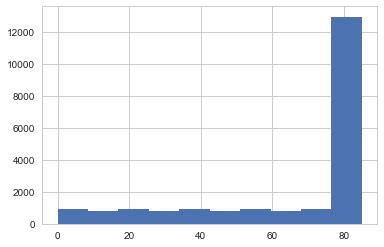

In [23]:
train_df_ref = train_df[['id', 'cycle'] + sensor_columns_var + agg_cols + ['RUL', 'label1', 'label2']]
train_df_ref['RUL'] = np.where(train_df_ref.RUL > max_rul, max_rul, train_df_ref.RUL)
display(train_df_ref.head())
train_df_ref['RUL'].hist()
plt.show()

starting RUL Linear
starting RUL Random Forest
starting RUL LSTM
starting label1 Linear
starting label1 Random Forrest
starting Label1 LSTM
starting label2 Linear
starting label2 Random Forrest
starting Label2 LSTM


,RUL,Label1,Label2
Benchmark,70.507539,25.0,53.0
Linear,12.138950,21.0,51.0
RandomForrest,10.430531,18.0,46.0
LSTM,5.457015,11.0,19.0


,RUL,Label1,Label2
Benchmark,70.507539,25.0,53.0
Linear,12.138950,21.0,51.0
RandomForrest,10.430531,18.0,46.0
LSTM,5.457015,11.0,19.0


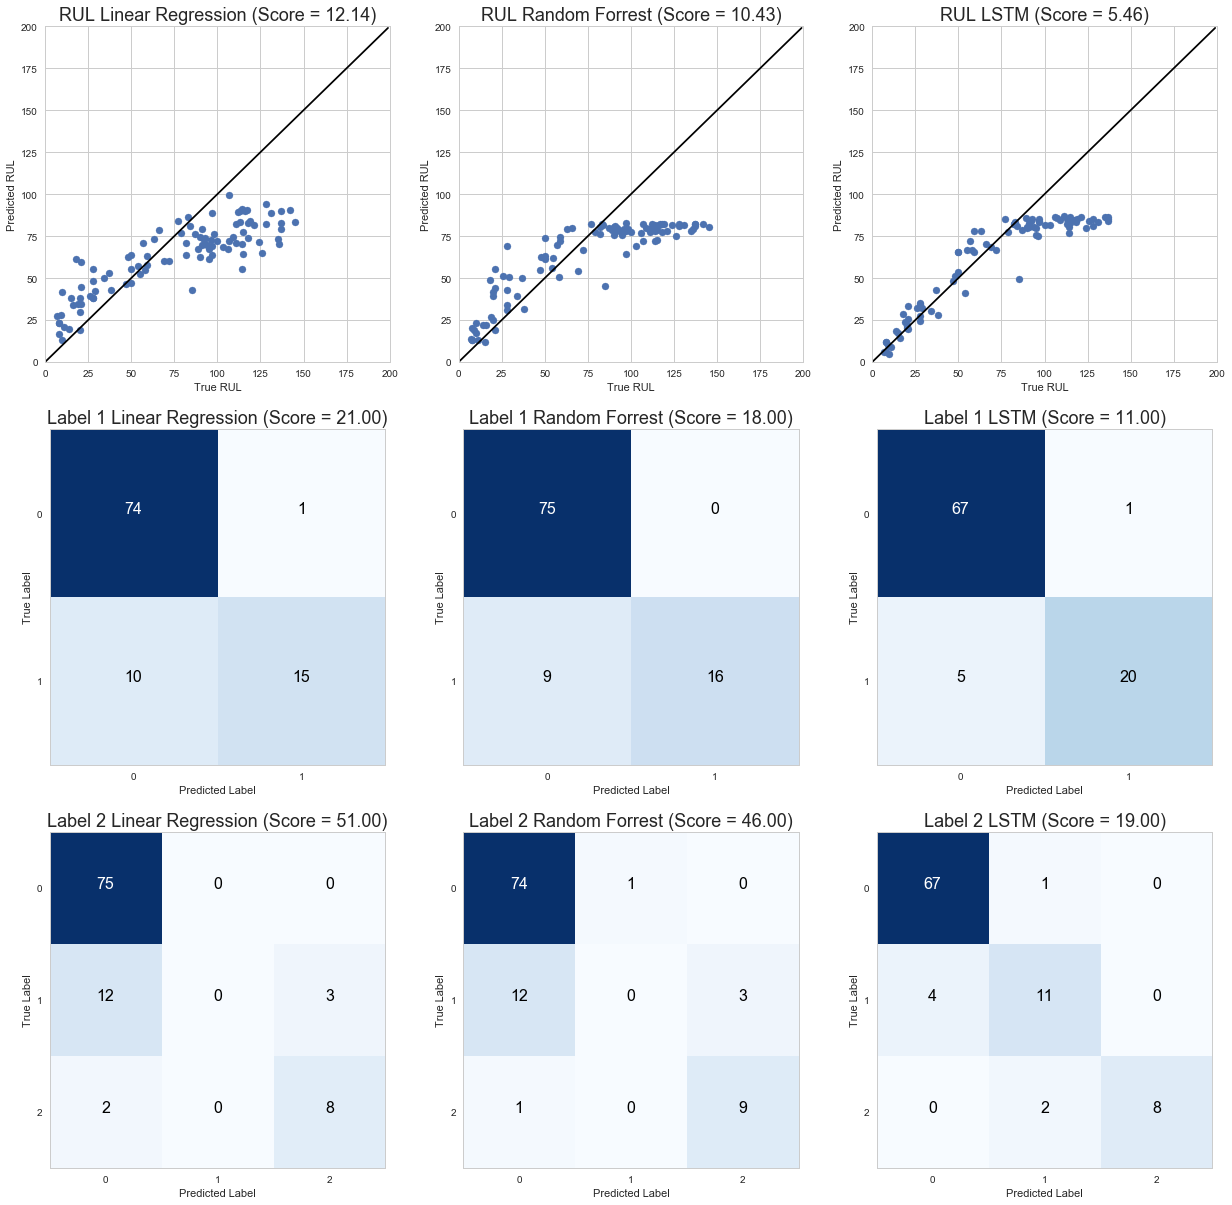

In [24]:
show_all_results(train_df_ref, test_df, train_rul=False, train_label1=False, train_label2=False, refine=True)